In [61]:
!pip install radcad
!pip install matplotlib
!pip install enforce_typing
!pip install names

In [1]:
# Dependences
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import enforce_typing
import math
import random

# Experiments
from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend

pd.options.display.float_format = '{:.2f}'.format

%matplotlib inline

# Check test data

In [19]:
dfA = pd.read_csv('near-usd-max.csv').tail(90).reset_index(drop=True)[['snapped_at', 'price']]
dfA.columns = ['snapped_at', 'price_A']
dfB = pd.read_csv('ocean-usd-max.csv').tail(90).reset_index(drop=True)[['snapped_at', 'price']]
dfB.columns = ['snapped_at', 'price_B']
dfm = dfA.merge(dfB, on='snapped_at')
dfm.to_csv('exogeneous_data.csv', index=False)

In [4]:
ed = pd.read_csv('exogeneous_data.csv')

In [31]:
"""
Model initial state.
"""

genesis_state = {
    'funded': 100,
    'disbursed': 20,
    'invested': 80,
    'project_kpi': 0,
}

In [32]:
def disburse_rate(timestep):
    if timestep < 30:
        rate = 0.5
    elif timestep < 60:
        rate = 1
    else:
        rate = 0.8
    return rate
    

def disburse_policy(params, step, h, s):
    """
    Update disbursed funds state.
    """
    timestep = len(h)
    if timestep == 0:
        return ({'disbursed': s['disbursed'] })
    disburse_per_day = disburse_rate(timestep)
    return ({
        'disbursed': s['disbursed'] + disburse_per_day
    })

def invest_policy(params, step, h, s):
    """
    Update invested funds state.
    """
    timestep = len(h)
    apr = 0.30
    daily_multiplier = (1 + apr / 365)
    disburse_per_day = disburse_rate(timestep)
    return ({'invested': (s['invested'] - disburse_per_day) * daily_multiplier})

def value_policy(params, step, h, s):
    """
    Update project performance state.
    """
    increment_per_day = random.randint(0,3)
    return ({'project_kpi': s['project_kpi'] + increment_per_day})

def update_disbursed(params, step, h, s, _input):
    return ('disbursed', _input['disbursed'])

def update_invested(params, step, h, s, _input):
    return ('invested', _input['invested'])

def update_project_kpi(params, step, h, s, _input):
    return ('project_kpi', _input['project_kpi'])


In [34]:
"""
Partial state update block. 

Here the partial state update blocks are configurated by setting
- policies
- variables

for each state update block individually
"""

partial_state_update_block = [
    {
        'policies': {
            'disburse_policy': disburse_policy,
            'invest_policy': invest_policy,
            'value_policy': value_policy
        },
        'variables': {
            'disbursed': update_disbursed,
            'invested': update_invested,
            'project_kpi': update_project_kpi
        },
    }
]

In [35]:
# T
SIMULATION_TIME_STEPS = 90
print("SIMULATION_TIME_STEPS: ", SIMULATION_TIME_STEPS)
# N monte carlo runs
MONTE_CARLO_RUNS = 1
print("MONTE_CARLO_RUNS: ", MONTE_CARLO_RUNS)

SIMULATION_TIME_STEPS:  90
MONTE_CARLO_RUNS:  1


In [36]:
model = Model(initial_state=genesis_state, state_update_blocks=partial_state_update_block, params=params)

simulation = Simulation(model=model, timesteps=SIMULATION_TIME_STEPS, runs=MONTE_CARLO_RUNS)

simulations = [simulation]
experiment = Experiment(simulations)
# Select the Pathos backend to avoid issues with multiprocessing and Jupyter Notebooks
experiment.engine = Engine(backend=Backend.PATHOS, drop_substeps=True)

result = experiment.run()

In [37]:
df = pd.DataFrame(result)
# rdf = df[df['substep'] == df.substep.max()]
df.head(90)

,funded,disbursed,invested,project_kpi,simulation,subset,run,substep,timestep
0,100,20.00,80.00,0,0,0,1,0,0
1,100,20.50,79.57,2,0,0,1,1,1
2,100,21.00,79.13,5,0,0,1,1,2
3,100,21.50,78.69,5,0,0,1,1,3
4,100,22.00,78.26,7,0,0,1,1,4
...,...,...,...,...,...,...,...,...,...
85,100,85.30,18.34,117,0,0,1,1,85
86,100,86.10,17.56,118,0,0,1,1,86
87,100,86.90,16.77,119,0,0,1,1,87
88,100,87.70,15.98,120,0,0,1,1,88


<AxesSubplot:>

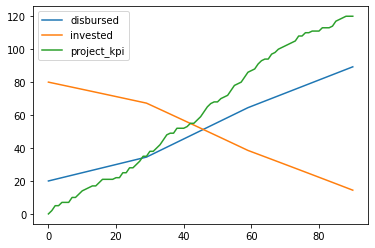

In [38]:
df[['disbursed', 'invested', 'project_kpi']].plot()

In [1]:
"""
Model initial state.
"""

genesis_state = {
    # 'funded': 100,
    # 'disbursed': 20,
    # 'invested': 80,
    'project_kpi': 0,

    'funded_A': 4,
    'funded_B': 55,
    'funded_S': 0,
    'invested_A': 3.6,
    'invested_B': 49.5,
    # 'invested_S': 0,
    'disbursed_A': 0.4,
    'disbursed_B': 5.5,
    # 'disbursed_S': 0,
    # 'project_kpi': 0,
    
    'price_A': 12.01,
    'price_B': 0.91
}

In [21]:
DATA = pd.read_csv('exogeneous_data.csv').to_dict(orient='index')

def disburse_rate_A(timestep):
    if timestep < 30:
        rate = 0.025
    elif timestep < 60:
        rate = 0.05
    else:
        rate = 0.04
    return rate

def disburse_rate_B(timestep):
    if timestep < 30:
        rate = 0.25
    elif timestep < 60:
        rate = 0.5
    else:
        rate = 0.4
    return rate

def disburse_policy(params, step, h, s):
    """
    Update disbursed funds state.
    """
    timestep = len(h)
    if timestep == 0:
        return ({
            'disbursed_A': s['disbursed_A'],
            'disbursed_B': s['disbursed_B']
        })
    disburse_per_day_A = disburse_rate_A(timestep)
    disburse_per_day_B = disburse_rate_B(timestep)
    return ({
        'disbursed_A': s['disbursed_A'] + disburse_per_day_A,
        'disbursed_B': s['disbursed_B'] + disburse_per_day_B
    })

def invest_policy(params, step, h, s):
    """
    Update invested funds state.
    """
    timestep = len(h)
    apr = 0.30
    daily_multiplier = (1 + apr / 365)
    disburse_per_day_A = disburse_rate_A(timestep)
    disburse_per_day_B = disburse_rate_B(timestep)
    return ({
        'invested_A': (s['invested_A'] - disburse_per_day_A) * daily_multiplier,
        'invested_B': (s['invested_B'] - disburse_per_day_B) * daily_multiplier,
    })

def value_policy(params, step, h, s):
    """
    Update project performance state.
    """
    increment_per_day = random.randint(0,3)
    return ({'project_kpi': s['project_kpi'] + increment_per_day})

def update_disbursed_A(params, step, h, s, _input):
    return ('disbursed_A', _input['disbursed_A'])

def update_disbursed_B(params, step, h, s, _input):
    return ('disbursed_B', _input['disbursed_B'])

def update_invested_A(params, step, h, s, _input):
    return ('invested_A', _input['invested_A'])

def update_invested_B(params, step, h, s, _input):
    return ('invested_B', _input['invested_B'])

def update_project_kpi(params, step, h, s, _input):
    return ('project_kpi', _input['project_kpi'])

def update_price_A(params, step, h, s, _input):
    timestep = len(h)
    price = DATA[timestep - 1]['price_A']
    return ('price_A', price)

def update_price_B(params, step, h, s, _input):
    timestep = len(h)
    price = DATA[timestep - 1]['price_B']
    return ('price_B', price)

In [22]:
"""
Partial state update block. 

Here the partial state update blocks are configurated by setting
- policies
- variables

for each state update block individually
"""

partial_state_update_block = [
    {
        'label': 'price updates',
        'policies': {},
        'variables': {
            'price_A': update_price_A,
            'price_B': update_price_B
        }
    },
    {
        'policies': {
            'disburse_policy': disburse_policy,
            'invest_policy': invest_policy,
            'value_policy': value_policy
        },
        'variables': {
            'disbursed_A': update_disbursed_A,
            'disbursed_B': update_disbursed_B,
            'invested_A': update_invested_A,
            'invested_B': update_invested_B,
            'project_kpi': update_project_kpi
        },
    }
]


In [23]:
# T
SIMULATION_TIME_STEPS = 90
print("SIMULATION_TIME_STEPS: ", SIMULATION_TIME_STEPS)
# N monte carlo runs
MONTE_CARLO_RUNS = 1
print("MONTE_CARLO_RUNS: ", MONTE_CARLO_RUNS)

SIMULATION_TIME_STEPS:  90
MONTE_CARLO_RUNS:  1


In [26]:
model2 = Model(initial_state=genesis_state, state_update_blocks=partial_state_update_block, params=params)

simulation2 = Simulation(model=model2, timesteps=SIMULATION_TIME_STEPS, runs=MONTE_CARLO_RUNS)

simulations2 = [simulation2]
experiment2 = Experiment(simulations2)
# Select the Pathos backend to avoid issues with multiprocessing and Jupyter Notebooks
experiment2.engine = Engine(backend=Backend.PATHOS, drop_substeps=True)

result = experiment2.run()

In [27]:
df = pd.DataFrame(result)
# rdf = df[df['substep'] == df.substep.max()]
df.head(90)

,project_kpi,funded_A,funded_B,funded_S,invested_A,invested_B,disbursed_A,disbursed_B,price_A,price_B,simulation,subset,run,substep,timestep
0,0,4,55,0,3.60,49.50,0.40,5.50,12.01,0.91,0,0,1,0,0
1,2,4,55,0,3.58,49.29,0.43,5.75,12.34,0.93,0,0,1,2,1
2,3,4,55,0,3.56,49.08,0.45,6.00,10.90,0.80,0,0,1,2,2
3,5,4,55,0,3.53,48.87,0.48,6.25,11.37,0.82,0,0,1,2,3
4,6,4,55,0,3.51,48.66,0.50,6.50,11.55,0.83,0,0,1,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,132,4,55,0,0.49,19.36,3.66,38.15,17.72,0.77,0,0,1,2,85
86,134,4,55,0,0.45,18.97,3.70,38.55,16.21,0.75,0,0,1,2,86
87,134,4,55,0,0.41,18.59,3.74,38.95,15.25,0.75,0,0,1,2,87
88,136,4,55,0,0.37,18.20,3.78,39.35,13.14,0.64,0,0,1,2,88


<AxesSubplot:>

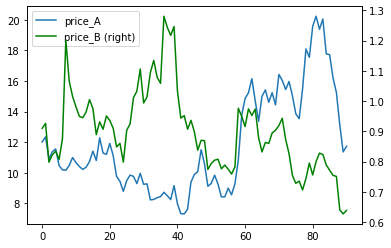

In [28]:
df["price_A"].plot(legend='price A')
df["price_B"].plot(secondary_y=True, style="g", legend='price B')

<AxesSubplot:>

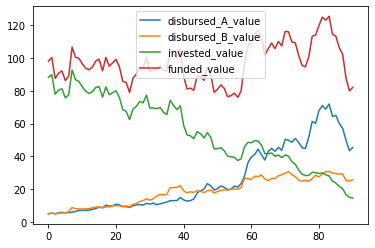

In [29]:
df['invested_value'] = df['invested_A'] * df['price_A'] + df['invested_B'] * df['price_B']
df['funded_value'] = df['funded_A'] * df['price_A'] + df['funded_B'] * df['price_B']
df['disbursed_A_value'] = df['disbursed_A'] * df['price_A']
df['disbursed_B_value'] = df['disbursed_B'] * df['price_B']

df[['disbursed_A_value', 'disbursed_B_value', 'invested_value', 'funded_value']].plot()

# Simulation - one funder

In [22]:
# Initial state for the model

genesis_state = {
    'price': 1.1,  # initial price of funding token
    'funded': 20,  # initial amount funded (# of tokens)
    'disbursed': 11,  # initial amount disbursed to contributors
    'invested': 10,  # initial amount invested
    'project_kpi': 0,  # initial impact measurement for project
}

In [36]:
DATA = pd.read_csv('exogeneous_data2.csv').to_dict(orient='index')

# Helper functions, policy functions and state updates

def funded_rate(timestep):
    # in token units
    if timestep < 30:
        rate = 0.5
    elif timestep < 60:
        rate = 1
    else:
        rate = 0.8
    return rate

def disbursed_rate(timestep):
    # in stable coin units
    if timestep < 30:
        rate = 0.5
    elif timestep < 60:
        rate = 0.5
    else:
        rate = 0.5
    return rate

def fund_policy(params, step, h, s):
    # stream part of cofund (lump-sum + stream) policy
    timestep = len(h)
    if timestep == 0:
        return ({'funded': s['funded'] })
    funded_per_day = funded_rate(timestep)
    return ({
        'funded': s['funded'] + funded_per_day
    })


def invest_policy(params, step, h, s):
    # update net-flow (withdrawals + interests) of invested sum
    timestep = len(h)
    apr = 0.30
    daily_multiplier = (1 + apr / 365)
    funded_per_day = funded_rate(timestep)
    disbursed_per_day = disbursed_rate(timestep) / s['price']
    return ({'invested': (s['invested'] + funded_per_day - disbursed_per_day) * daily_multiplier})

def disburse_policy(params, step, h, s):
    # update disbursed funds state
    timestep = len(h)
    disbursed_per_day = disbursed_rate(timestep)
    return ({'disbursed': s['disbursed'] + disbursed_per_day})

def value_policy(params, step, h, s):
    # update project performance state
    increment_per_day = random.randint(0,4) / 3
    return ({'project_kpi': s['project_kpi'] + increment_per_day})

def update_funded(params, step, h, s, _input):
    return ('funded', _input['funded'])

def update_invested(params, step, h, s, _input):
    return ('invested', _input['invested'])

def update_disbursed(params, step, h, s, _input):
    return ('disbursed', _input['disbursed'])

def update_project_kpi(params, step, h, s, _input):
    return ('project_kpi', _input['project_kpi'])

def update_price(params, step, h, s, _input):
    timestep = len(h)
    price = DATA[timestep - 1]['price_B']
    return ('price', price)

In [15]:
# Partial state update block

partial_state_update_block = [
    {
        'label': 'price updates',
        'policies': {},
        'variables': {
            'price': update_price
        }
    },
    {
        'policies': {
            'fund_policy': fund_policy,
            'disburse_policy': disburse_policy,
            'invest_policy': invest_policy,
            'value_policy': value_policy
        },
        'variables': {
            'funded': update_funded,
            'disbursed': update_disbursed,
            'invested': update_invested,
            'project_kpi': update_project_kpi
        },
    }
]

In [37]:
SIMULATION_TIME_STEPS = 90
print("SIMULATION_TIME_STEPS: ", SIMULATION_TIME_STEPS)

MONTE_CARLO_RUNS = 1
print("MONTE_CARLO_RUNS: ", MONTE_CARLO_RUNS)

SIMULATION_TIME_STEPS:  90
MONTE_CARLO_RUNS:  1


In [38]:
model3 = Model(initial_state=genesis_state, state_update_blocks=partial_state_update_block, params={})

simulation3 = Simulation(model=model3, timesteps=SIMULATION_TIME_STEPS, runs=MONTE_CARLO_RUNS)

simulations3 = [simulation3]
experiment3 = Experiment(simulations3)
experiment3.engine = Engine(backend=Backend.PATHOS, drop_substeps=True) # pathos backend to avoid issues with multiprocessing in .nb

result = experiment3.run()

df = pd.DataFrame(result)
df.head(90)

,price,funded,disbursed,invested,project_kpi,simulation,subset,run,substep,timestep
0,1.10,20.00,11.00,10.00,0.00,0,0,1,0,0
1,1.11,20.50,11.50,10.06,0.33,0,0,1,2,1
2,0.99,21.00,12.00,10.06,0.67,0,0,1,2,2
3,1.01,21.50,12.50,10.08,0.67,0,0,1,2,3
4,1.09,22.00,13.00,10.13,0.67,0,0,1,2,4
...,...,...,...,...,...,...,...,...,...,...
85,0.61,85.30,53.50,20.98,57.00,0,0,1,2,85
86,0.61,86.10,54.00,20.97,58.00,0,0,1,2,86
87,0.56,86.90,54.50,20.90,58.33,0,0,1,2,87
88,0.54,87.70,55.00,20.79,58.67,0,0,1,2,88


In [44]:
# Calculate cumulative disbursed amount in token units
df['disbursed_diff'] = df['disbursed'].diff()
df['disbursed_diff'].iloc[0] = 11.0

df['disbursed_diff_tkn'] = df['disbursed_diff'] / df['price']
df['disbursed_tkn'] = df['disbursed_diff_tkn'].cumsum()

/Users/davide/Documents/projects/blockscience/venv_rai/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [45]:
# Calculate funded, invested value in stable
df['funded_val'] = df['funded']*df['price']
df['invested_val'] = df['invested']*df['price']

In [46]:
df['tot_val'] = df['invested_val']+df['disbursed']
df['tot_tkn'] = df['invested']+df['disbursed_tkn']

In [47]:
df[['funded', 'invested', 'disbursed_tkn']]

,funded,invested,disbursed_tkn
0,20.00,10.00,10.00
1,20.50,10.06,10.45
2,21.00,10.06,10.96
3,21.50,10.08,11.45
4,22.00,10.13,11.90
...,...,...,...
86,86.10,20.97,66.23
87,86.90,20.90,67.13
88,87.70,20.79,68.05
89,88.50,20.60,69.06


Text(0, 0.5, '$TKN Price')

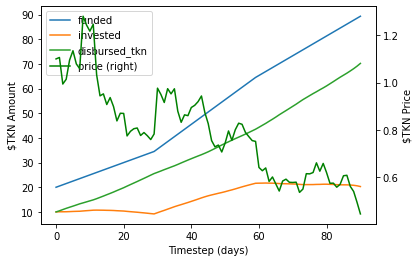

In [48]:
# dp = df[['funded', 'invested', 'disbursed_tkn']]
# dp.columns = ['funded_tkn', 'invested', 'disbursed_tkn']
df[['funded', 'invested', 'disbursed_tkn']].plot()
plt.xlabel('Timestep (days)')
plt.ylabel('$TKN Amount')
df["price"].plot(secondary_y=True, style="g", legend='price')
plt.ylabel('$TKN Price')

In [34]:
df.to_csv('~/cofund-sim.csv')

# Simulation - two funders

In [50]:
# Setup model states
from collections import defaultdict

genesis_state = {
    'price': defaultdict(A=12.01, B=0.91),
    'funded': defaultdict(A=4, B=55),
    'invested': defaultdict(A=3.6, B=49.5, S=0),
    'disbursed': 0,
    'project_kpi': 0,
}

In [51]:
DATA = pd.read_csv('exogeneous_data.csv').to_dict(orient='index')

# Helper functions, policy functions and state updates

def funded_rate(timestep):
    # in token units
    if timestep < 30:
        rate = 0.5
    elif timestep < 60:
        rate = 1
    else:
        rate = 0.8
    return {'A': rate, 'B': rate}

def disbursed_rate(timestep):
    # in stable coin units
    if timestep < 30:
        rate = 0.65
    elif timestep < 60:
        rate = 0.5
    else:
        rate = 0.35
    return rate

def fund_policy(params, step, h, s):
    # stream part of cofund (lump-sum + stream) policy
    timestep = len(h)
    if timestep == 0:
        funded = {'A': s['funded']['A'], 'B': s['funded']['B']}
    else:
        funded_per_day = funded_rate(timestep)
        funded = {
            'A': s['funded']['A'] + funded_per_day['A'],
            'B': s['funded']['B'] + funded_per_day['B'],
        }
    return ({
        'funded': funded
    })


def invest_policy(params, step, h, s):
    # update net-flow (withdrawals + interests) of invested sum
    timestep = len(h)
    apr = 0.30
    daily_multiplier = (1 + apr / 365)
    funded_per_day = funded_rate(timestep)
    disbursed_per_day = {
        # for now assume that disbursed is payed (1/2,1/2) from each token balance
        'A': disbursed_rate(timestep) / (2*s['price']['A']),
        'B': disbursed_rate(timestep) / (2*s['price']['B']),
    }
    invested = {
        'A': (s['invested']['A'] + funded_per_day['A'] - disbursed_per_day['A']) * daily_multiplier,
        'B': (s['invested']['B'] + funded_per_day['B'] - disbursed_per_day['B']) * daily_multiplier,
        'S': 0,
    }
    return ({'invested': invested})

def disburse_policy(params, step, h, s):
    # update disbursed funds state
    timestep = len(h)
    disbursed_per_day = disbursed_rate(timestep)
    return ({'disbursed': s['disbursed'] + disbursed_per_day})

def value_policy(params, step, h, s):
    # update project performance state
    increment_per_day = random.randint(0,4) / 3
    return ({'project_kpi': s['project_kpi'] + increment_per_day})

def update_funded(params, step, h, s, _input):
    return ('funded', _input['funded'])

def update_invested(params, step, h, s, _input):
    return ('invested', _input['invested'])

def update_disbursed(params, step, h, s, _input):
    return ('disbursed', _input['disbursed'])

def update_project_kpi(params, step, h, s, _input):
    return ('project_kpi', _input['project_kpi'])

def update_price(params, step, h, s, _input):
    timestep = len(h)
    price = {'A': DATA[timestep - 1]['price_A'], 'B': DATA[timestep - 1]['price_B']}
    return ('price', price)

In [52]:
# Partial state update block

partial_state_update_block = [
    {
        'label': 'price updates',
        'policies': {},
        'variables': {
            'price': update_price
        }
    },
    {
        'policies': {
            'fund_policy': fund_policy,
            'disburse_policy': disburse_policy,
            'invest_policy': invest_policy,
            'value_policy': value_policy
        },
        'variables': {
            'funded': update_funded,
            'disbursed': update_disbursed,
            'invested': update_invested,
            'project_kpi': update_project_kpi
        },
    }
]


In [53]:
SIMULATION_TIME_STEPS = 90
print("SIMULATION_TIME_STEPS: ", SIMULATION_TIME_STEPS)

MONTE_CARLO_RUNS = 1
print("MONTE_CARLO_RUNS: ", MONTE_CARLO_RUNS)

SIMULATION_TIME_STEPS:  90
MONTE_CARLO_RUNS:  1


In [56]:
model = Model(initial_state=genesis_state, state_update_blocks=partial_state_update_block, params={})

simulation = Simulation(model=model, timesteps=SIMULATION_TIME_STEPS, runs=MONTE_CARLO_RUNS)

simulations = [simulation]
experiment = Experiment(simulations)
experiment.engine = Engine(backend=Backend.PATHOS, drop_substeps=True) # pathos backend to avoid issues with multiprocessing in .nb

result = experiment.run()

df = pd.DataFrame(result)

In [60]:
for k in genesis_state['price'].keys():
    df['price_'+k] = df['price'].apply(lambda x: x[k])
    df['funded_'+k] = df['funded'].apply(lambda x: x[k])
    df['invested_'+k] = df['invested'].apply(lambda x: x[k])
    
df.drop(columns=['price', 'funded', 'invested'])

,disbursed,project_kpi,simulation,subset,run,substep,timestep,price_A,funded_A,invested_A,price_B,funded_B,invested_B
0,0.00,0.00,0,0,1,0,0,12.01,4.00,3.60,0.91,55.00,49.50
1,0.65,0.67,0,0,1,2,1,12.34,4.50,4.08,0.93,55.50,49.69
2,1.30,1.00,0,0,1,2,2,10.90,5.00,4.55,0.80,56.00,49.82
3,1.95,1.33,0,0,1,2,3,11.37,5.50,5.03,0.82,56.50,49.97
4,2.60,1.67,0,0,1,2,4,11.55,6.00,5.50,0.83,57.00,50.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,43.30,55.33,0,0,1,2,86,16.21,70.10,70.05,0.75,121.10,96.55
87,43.65,56.33,0,0,1,2,87,15.25,70.90,70.90,0.75,121.90,97.20
88,44.00,56.67,0,0,1,2,88,13.14,71.70,71.74,0.64,122.70,97.80
89,44.35,57.67,0,0,1,2,89,11.36,72.50,72.59,0.63,123.50,98.41
